# Data exploration

In this notebook, we explore the training data with the aim of identifying their main characteristics and trends, which will be exploited in the subsequent analysis.

In [1]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
stationsData = spark.read.load("/user/garza/LabReply/ProjectData/stations.csv", format="csv", delimiter="\t", header=True, inferSchema=True)

In [3]:
stationsData.printSchema()
stationsData.show()

root
 |-- id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- name: string (nullable = true)

+---+---------+---------+--------------------+
| id|longitude| latitude|                name|
+---+---------+---------+--------------------+
|  1| 2.180019|41.397978|Gran Via Corts Ca...|
|  2| 2.176414|41.394381|       Plaza TetuÃ¡n|
|  3| 2.181164| 41.39375|             Ali Bei|
|  4|   2.1814|41.393364|               Ribes|
|  5| 2.180214|41.391072|  Pg LluÃ­s Companys|
|  6| 2.180508|41.391272|  Pg LluÃ­s Companys|
|  7| 2.183183|41.388867|  Pg LluÃ­s Companys|
|  8| 2.183453|41.389044|Passeig lluÃ­s co...|
|  9| 2.185294|41.385006|MarquÃ¨s de l\'Ar...|
| 10| 2.185206|41.384875|Avinguda del Marq...|
| 11| 2.183622|41.385394|             ComerÃ§|
| 12| 2.193939|41.381681|            Trelawny|
| 13| 2.195661|41.384522|pg marÃ­tim barce...|
| 14| 2.195603|41.384417|     Passeig Maritim|
| 15| 2.195706|41.386811|       Avda. Litor

In [4]:
trainData = spark.read.load("/user/garza/LabReply/ProjectData/trainingData.csv", format="csv", header=True, inferSchema=True)

In [5]:
trainData.printSchema()
trainData.show()

root
 |-- StationId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- NumBikes-4: integer (nullable = true)
 |-- NumBikes-3: integer (nullable = true)
 |-- NumBikes-2: integer (nullable = true)
 |-- NumBikes-1: integer (nullable = true)
 |-- NumBikes: integer (nullable = true)
 |-- NumBikes+1: integer (nullable = true)

+---------+-------------------+----------+----------+----------+----------+--------+----------+
|StationId|          Timestamp|NumBikes-4|NumBikes-3|NumBikes-2|NumBikes-1|NumBikes|NumBikes+1|
+---------+-------------------+----------+----------+----------+----------+--------+----------+
|      104|2008-05-15 12:00:00|         0|         1|         2|         3|       2|         1|
|      108|2008-05-15 12:00:00|         0|         0|         0|         0|       1|         1|
|      112|2008-05-15 12:00:00|         0|         0|         1|         0|       0|         0|
|      113|2008-05-15 12:00:00|         0|         0|         0|         0| 

In [6]:
joinedTrainData = trainData.join(stationsData, trainData.StationId == stationsData.id)

In [7]:
testData = spark.read.load("/user/garza/LabReply/ProjectData/testData.csv", format="csv", header=True, inferSchema=True)

In [8]:
testData.printSchema()
testData.show()

root
 |-- StationId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- NumBikes-4: integer (nullable = true)
 |-- NumBikes-3: integer (nullable = true)
 |-- NumBikes-2: integer (nullable = true)
 |-- NumBikes-1: integer (nullable = true)
 |-- NumBikes: integer (nullable = true)
 |-- NumBikes+1: integer (nullable = true)

+---------+-------------------+----------+----------+----------+----------+--------+----------+
|StationId|          Timestamp|NumBikes-4|NumBikes-3|NumBikes-2|NumBikes-1|NumBikes|NumBikes+1|
+---------+-------------------+----------+----------+----------+----------+--------+----------+
|      122|2008-09-01 05:00:00|         0|         0|         0|         0|       0|         0|
|       16|2008-09-01 05:00:00|         0|         0|         0|         0|       0|         0|
|      163|2008-09-01 05:00:00|         0|         0|         0|         0|       0|         0|
|      170|2008-09-01 05:00:00|         0|         0|         0|         0| 

In [9]:
joinedTestData = testData.join(stationsData, testData.StationId == stationsData.id)

## Preliminary analysis

**Main dataset statistics**

The training dataset contains 2300356 records, each related to a bike sharing station (identified by an integer between 1 and 283) and a timestamp.

Each record presents six numerical attributes (`NumBikes-4`, `NumBikes-3`, `NumBikes-2`, `NumBikes-1`, `NumBikes`, `NumBikes+1`) that represent the number of bikes respectively 40, 30, 20, 10 minutes before the timestamp, at the timestamp, and 10 minutes after the timestamp. The value of those attributes range from 0 to 39, with an average around 7.

Finally, after the join with the stations dataset, each record is also associated to the geographical coordinates of the corresponding station; those are characterized by a low standard deviation, sign that all stations are concentrated in a small area (the city of Barcelona).

In [10]:
joinedTrainData.describe(["StationId", "NumBikes-4", "NumBikes-3", "NumBikes-2", "NumBikes-1", "NumBikes", "NumBikes+1", "latitude", "longitude"]).show()

+-------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+
|summary|         StationId|       NumBikes-4|       NumBikes-3|       NumBikes-2|       NumBikes-1|         NumBikes|       NumBikes+1|         latitude|          longitude|
+-------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+
|  count|           2300356|          2300356|          2300356|          2300356|          2300356|          2300356|          2300356|          2300356|            2300356|
|   mean|142.25959547130967|7.730922518079811|7.723907516923467|7.717727169185987|7.711313814035741|7.704584420846165|7.697069931784472|41.39870283827549| 2.1738390841336073|
| stddev| 81.88598798917035|7.313675431758602|7.312533572117935| 7.31196649704901|7.311462964882302|7.311191780924354|7.31123

**Missing values identification**

The dataset does not contain any missing value, for any of its attributes.

In [11]:
joinedTrainData.select([F.sum(F.when(F.isnull(col), 1).otherwise(0)).alias(col) for col in joinedTrainData.columns]).show()

+---------+---------+----------+----------+----------+----------+--------+----------+---+---------+--------+----+
|StationId|Timestamp|NumBikes-4|NumBikes-3|NumBikes-2|NumBikes-1|NumBikes|NumBikes+1| id|longitude|latitude|name|
+---------+---------+----------+----------+----------+----------+--------+----------+---+---------+--------+----+
|        0|        0|         0|         0|         0|         0|       0|         0|  0|        0|       0|   0|
+---------+---------+----------+----------+----------+----------+--------+----------+---+---------+--------+----+



**Correlation among features**

When dealing with a machine learning problem, understanding the correlation among available features is an essential step to perform a meaningful analysis.

In our case, we studied the correlation among all the available features (including the station ID and its geolocation), as shown in the correlation matrix below. First, we observe a significant correlation among the features related to the number of available bikes, which gets even higher for values that are closer in time. This is is somehow expected, since we are dealing with a time series and so it is meaningful that the values observed at later instants of time depend on the previous values. On the other hand, all the other features do not seem to be correlated with each other.

In [12]:
featuresCols = ["StationId", "NumBikes-4", "NumBikes-3", "NumBikes-2", "NumBikes-1", "NumBikes", "NumBikes+1", "latitude", "longitude"]
corrMatrix = Correlation.corr(
    VectorAssembler(inputCols=featuresCols, outputCol="features").transform(joinedTrainData), "features").collect()[0]["pearson(features)"].toArray()

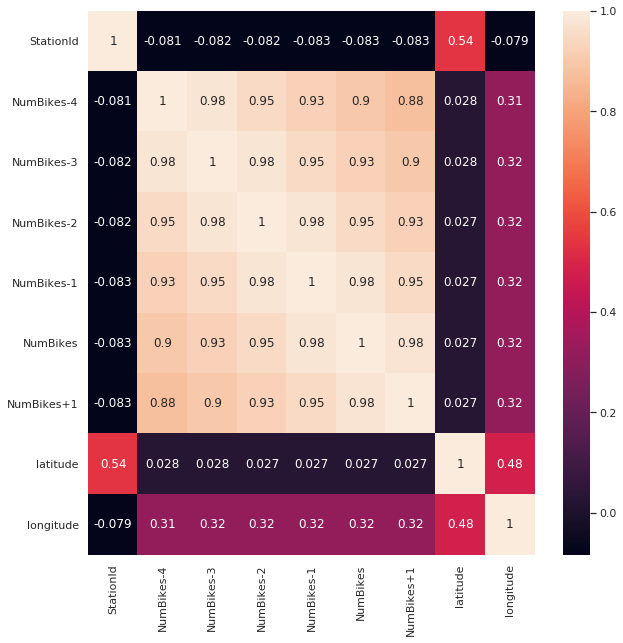

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrMatrix, annot=True, xticklabels=featuresCols, yticklabels=featuresCols, ax=ax);

**Record count by StationId**

We observe that essentially all the stations are associated to the same number of records (8460), with two exceptions:
* Station 44, which is associated to 8454 readings.
* Station 259, which is associated to 7702 readings.

In [14]:
countById = joinedTrainData.groupBy("StationId").agg(F.count("*").alias("Count")).toPandas()

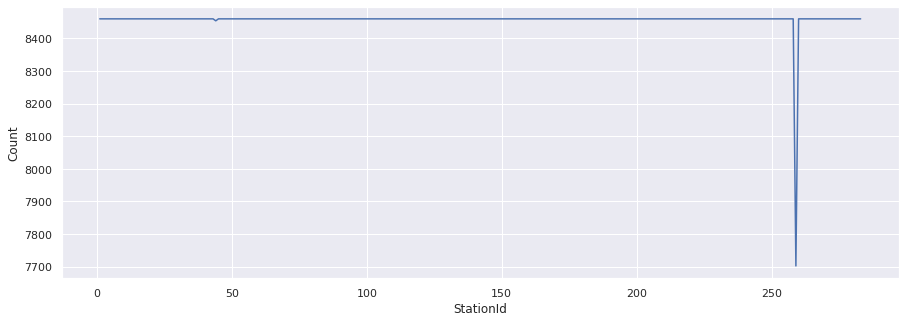

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=countById, x="StationId", y="Count", ax=ax);

**Distribution of raw bikes availability**

We observe that the great majority of the observations record very low readings (with a peak in zero). Still, there is a very long tail of values, which ranges up to 39.

In [16]:
rawBikesAvailability = joinedTrainData \
    .select(F.explode(F.array(["NumBikes-4", "NumBikes-3", "NumBikes-2", "NumBikes-1", "NumBikes", "NumBikes+1"])).alias("NumBikes")) \
    .groupBy("NumBikes") \
    .agg(F.count("*").alias("Count")) \
    .toPandas()

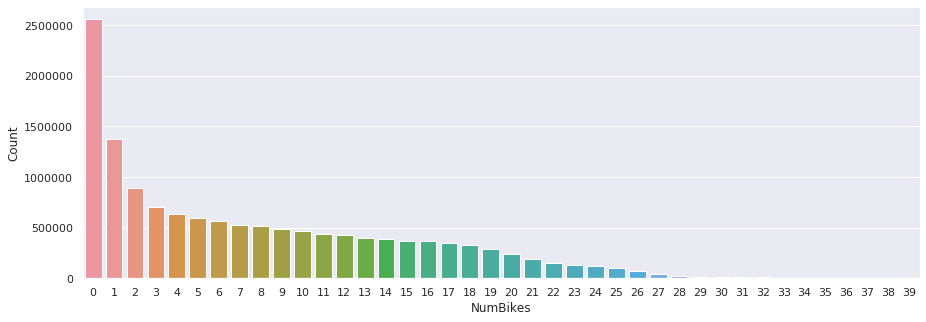

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=rawBikesAvailability, x="NumBikes", y="Count");

**Cumulative distribution of raw bikes availability, in relative amounts**

As before, we observe that the majority of the readings are in the "low" part of the graph, with the 99% of readings being lower than the threshold value of 25. 

In [18]:
from pyspark.sql import Window

cumulativeBikesAvailability = joinedTrainData \
    .select(F.explode(F.array(["NumBikes-4", "NumBikes-3", "NumBikes-2", "NumBikes-1", "NumBikes", "NumBikes+1"])).alias("NumBikes")) \
    .groupBy("NumBikes") \
    .agg(F.count("*").alias("Count")) \
    .withColumn("CumFrac", F.sum("Count").over(Window.orderBy("NumBikes").rowsBetween(Window.unboundedPreceding, 0)) / sum(rawBikesAvailability["Count"])) \
    .toPandas()

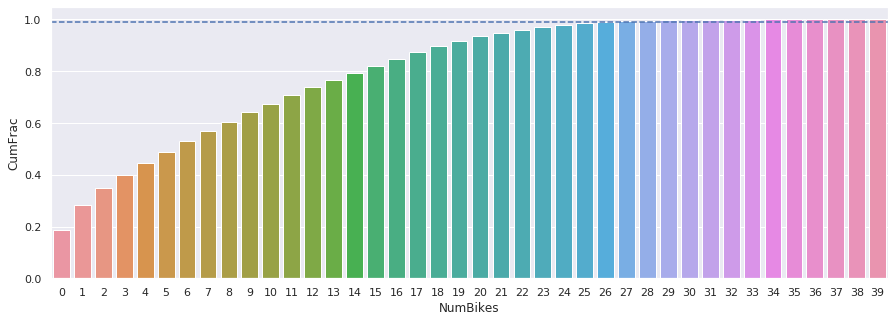

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=cumulativeBikesAvailability, x="NumBikes", y="CumFrac")
ax.axhline(0.99, ls='--');

In [20]:
cumulativeBikesAvailability[cumulativeBikesAvailability["CumFrac"] < 0.99]["NumBikes"].max()

25

## Timestamp dependence

**Average number of bikes (in all stations) by distinct timestamp**

We observe that:
* All the train data has been collected between 2008-05-15 and 2008-08-31, with a "hole" in the month of July.
* The resulting time series is not stationary, i.e., it does not have zero mean: there is a sort of a growing pattern in the month of August.

In [21]:
bikesByTime = joinedTrainData \
    .groupBy(joinedTrainData.Timestamp) \
    .agg(F.avg("NumBikes+1").alias("AvgBikes")) \
    .toPandas()

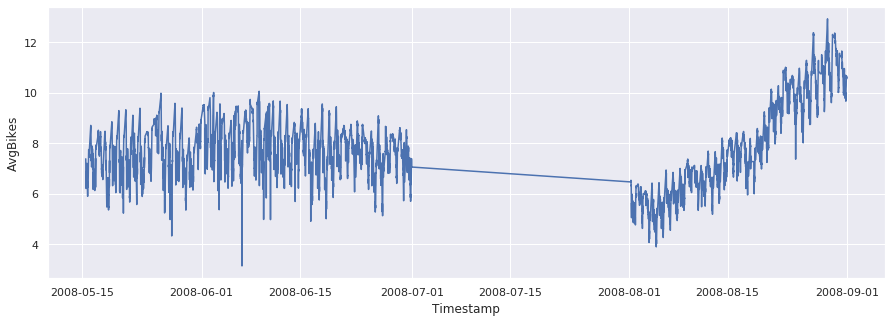

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=bikesByTime, x="Timestamp", y="AvgBikes", ax=ax);

**Average number of bikes (in all stations) by timestamp hour**

We notice that the bike usage is higher (i.e., the number of available bikes is lower) during the day, and especially in the evening (from 18.00 to 20.00). Still, there is not much variation in the system as a whole (difference between peak values is rather small).

In [23]:
bikesByHour = joinedTrainData \
    .groupBy(F.hour(joinedTrainData.Timestamp).alias("Hour")) \
    .agg(F.avg("NumBikes+1").alias("AvgBikes")) \
    .toPandas()

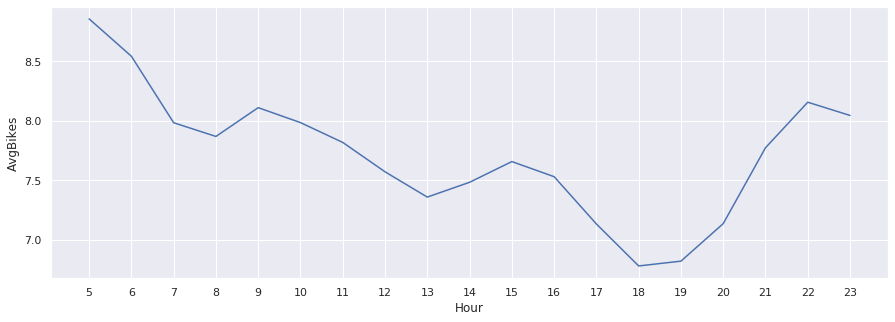

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=bikesByHour, x="Hour", y="AvgBikes", ax=ax)
ax.set_xticks(range(5, 24));

**Per-station trend (increasing, stable, decreasing) by timestamp hour**

The graph shows how many combinations (stationId, hour) present an increasing (1), stable (0), or decreasing (-1) number of bikes from NumBikes-4 to NumBikes+1. We observe a pretty uniform distribution, with some interesting insights:
* Throughout the day, most stations observe a decreasing trend, except for the hour range between 14.00 and 15.00.
* In the evening (from 19.00 on), the number of stations with an increasing trend becomes higher.

This may be justified as people are more incline to use the bikes during the day, making the availability go lower; at night, they return their bikes, so that the availability goes up again.

In [25]:
trendByHour = joinedTrainData \
    .withColumn("Trend", F.when(F.col("NumBikes+1") > F.col("NumBikes-4"), 1).when(F.col("NumBikes+1") == F.col("NumBikes-4"), 0).otherwise(-1)) \
    .groupBy(F.hour(joinedTrainData.Timestamp).alias("Hour"), "Trend") \
    .agg(F.count("*").alias("Count")) \
    .toPandas()

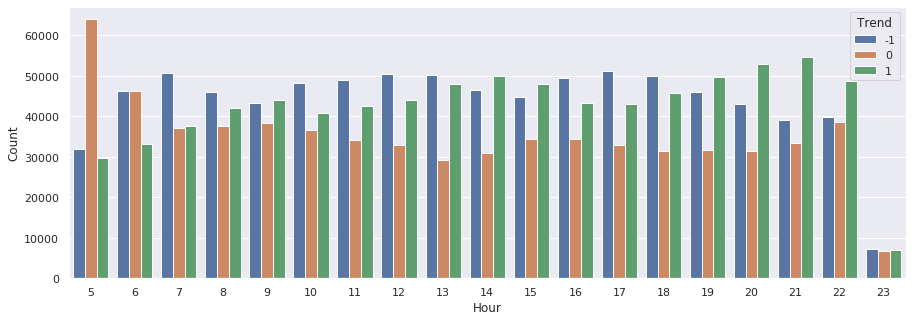

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=trendByHour, x="Hour", y="Count", hue="Trend", ax=ax);

**Average number of bikes (in all stations) by timestamp day of week**

We notice that the bike usage is higher (i.e., the number of available bikes is lower) during the week, with the lowest overall availability on Tuesday. Again, however, there is not much variation in the system as a whole (difference between peak values is rather small).

In [27]:
bikesByWeekday = joinedTrainData \
    .groupBy(F.dayofweek(joinedTrainData.Timestamp).alias("DayOfWeek")) \
    .agg(F.avg("NumBikes+1").alias("AvgBikes")) \
    .toPandas()

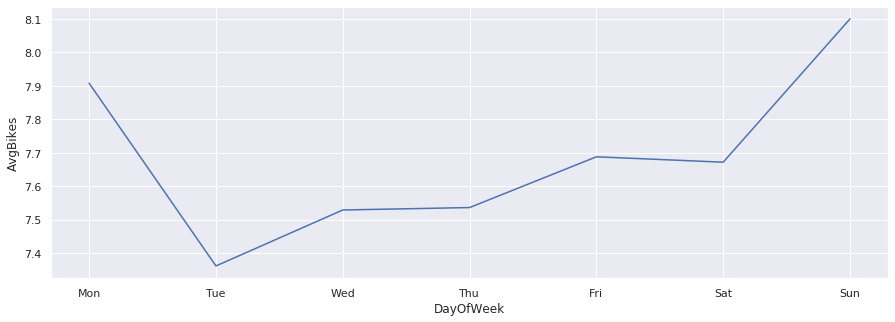

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=bikesByWeekday, x="DayOfWeek", y="AvgBikes", ax=ax)
ax.set_xticks(range(1, 8))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);

## Geolocation dependence

The map below shows the position of the bike sharing stations in the city of Barcelona. For each station, the color and size of the marker represents the average number of bikes in the station, considering all the timestamps.

In [29]:
avgBikesPerStation = joinedTrainData \
    .groupBy("StationId", "latitude", "longitude") \
    .agg(F.avg("NumBikes+1").alias("AvgNumBikes")) \
    .withColumn("AvgNumBikes", F.floor(F.col("AvgNumBikes") / 3)) \
    .toPandas()

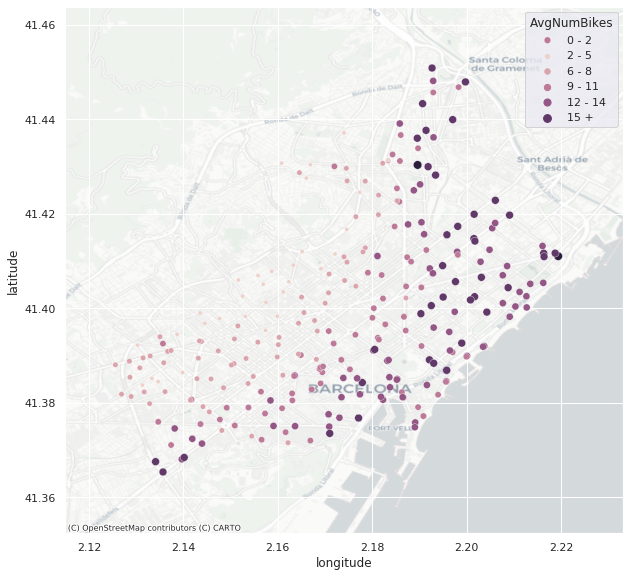

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=avgBikesPerStation, x="longitude", y="latitude", hue="AvgNumBikes", size="AvgNumBikes", ax=ax)
ax.legend(title="AvgNumBikes", labels=["0 - 2", "2 - 5", "6 - 8", "9 - 11", "12 - 14", "15 +"])
cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Positron)

## First order differences

In time series analysis, a common technique to handle data with large differences (in absolute terms) among the different variables of interest is to compute and use, for the purpose of the analysis, the first order differences among the lag variables that describe the data at different time instants. In our case, first order differences may be used to "compare" the data from stations with an average large number of available bikes with those with lower average availability.

In practice, from our original 6 features, we derive 5 `Diff` features by computing the pairwise difference between any two pair of consecutive readings.

In [31]:
diffTrainData = joinedTrainData \
    .withColumn("MaxNumBikes", F.greatest("NumBikes-4", "NumBikes-3", "NumBikes-2", "NumBikes-1", "NumBikes", "NumBikes+1")) \
    .withColumn("NumBikesDiff-3", (F.col("NumBikes-3") - F.col("NumBikes-4"))) \
    .withColumn("NumBikesDiff-2", (F.col("NumBikes-2") - F.col("NumBikes-3"))) \
    .withColumn("NumBikesDiff-1", (F.col("NumBikes-1") - F.col("NumBikes-2"))) \
    .withColumn("NumBikesDiff", (F.col("NumBikes") - F.col("NumBikes-1"))) \
    .withColumn("NumBikesDiff+1", (F.col("NumBikes+1") - F.col("NumBikes")))

**Diff dataset statistics**

With respect to the previous case, we observe that by applying the difference operator the features that we obtain are centered around 0, as we can appreciate from the computed average values. Despite the low standard deviation, also in this case we observe some pretty high minimum and maximum values (-27 and +28 respectively), indicative of a distribution that is quite condensed near its average of 0, but with some long tails comprised of very rare occurrences, as we shall see in the following graphs.

In [32]:
diffTrainData.describe(["StationId", "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikesDiff+1", "latitude", "longitude"]).show()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+
|summary|         StationId|      NumBikesDiff-3|      NumBikesDiff-2|      NumBikesDiff-1|        NumBikesDiff|      NumBikesDiff+1|         latitude|          longitude|
+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+
|  count|           2300356|             2300356|             2300356|             2300356|             2300356|             2300356|          2300356|            2300356|
|   mean|142.25959547130967|-0.00701500115634...|-0.00618034773748...|-0.00641335515024631|-0.00672939318957...|-0.00751448906169306|41.39870283827549| 2.1738390841336073|
| stddev| 81.88598798917035|  1.4977695623792446|  1.4998041310643992|   1.501377652270831|  1.5037514073503357|  1.5062343921062493|0.01854

**Raw and cumulative bikes differences**

The graphs below show the distribution of the `Diff` features produced at the previous step. As expected, we observe a pretty non-uniform distribution, with a very high peak in 0 (3 times higher than the -1 class, which is the second highest). The same trend is observed in the cumulative distribution.

Given the presence of negative values (stations that had more bikes at the previous instant with respect to the considered one), in this case we may define both a lower (1%) and an upper (99%) confidence thresholds for the obtained distribution, which result respectively at values -4 and +3.

In [33]:
diffRawBikesAvailability = diffTrainData \
    .select(F.explode(F.array(["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikesDiff+1"])).alias("NumBikesDiff")) \
    .groupBy("NumBikesDiff") \
    .agg(F.count("*").alias("Count")) \
    .toPandas()

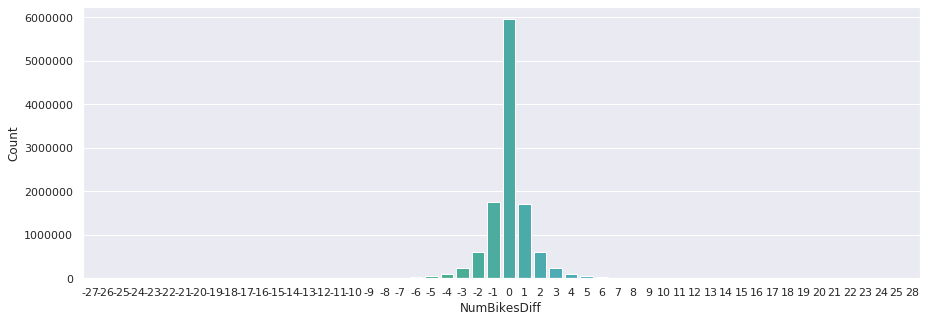

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=diffRawBikesAvailability, x="NumBikesDiff", y="Count");

In [35]:
diffCumulativeBikesAvailability = diffTrainData \
    .select(F.explode(F.array(["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikesDiff+1"])).alias("NumBikesDiff")) \
    .groupBy("NumBikesDiff") \
    .agg(F.count("*").alias("Count")) \
    .withColumn("CumFrac", F.sum("Count").over(Window.orderBy("NumBikesDiff").rowsBetween(Window.unboundedPreceding, 0)) / F.sum("Count").over(Window.rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing))) \
    .toPandas()

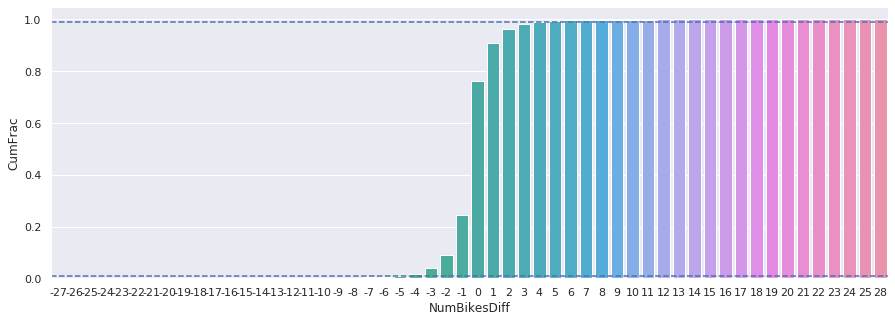

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=diffCumulativeBikesAvailability, x="NumBikesDiff", y="CumFrac")
ax.axhline(0.01, ls="--")
ax.axhline(0.99, ls='--');

In [37]:
diffCumulativeBikesAvailability[diffCumulativeBikesAvailability["CumFrac"] < 0.99]["NumBikesDiff"].max()

3

In [38]:
diffCumulativeBikesAvailability[diffCumulativeBikesAvailability["CumFrac"] > 0.01]["NumBikesDiff"].min()

-4

**Average availability difference (in all stations) by distinct timestamp**

With respect to the previous case, we observe that differencing the dataset had the consequence of making the distribution of observations stationary with respect to their timestamp.

In [39]:
diffByTime = diffTrainData \
    .groupBy(joinedTrainData.Timestamp) \
    .agg(F.avg("NumBikesDiff+1").alias("AvgBikesDiff")) \
    .toPandas()

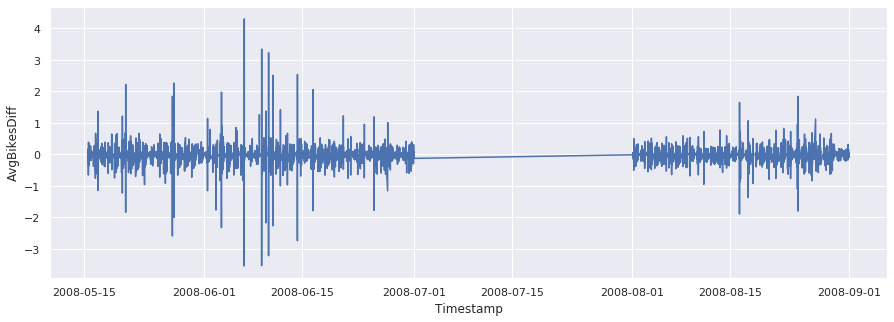

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=diffByTime, x="Timestamp", y="AvgBikesDiff", ax=ax);